In [2]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
from datetime import datetime as dt
import pickle
import xgboost as xgb

/Users/toshio/.pyenv/versions/anaconda3-4.3.0/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df=pd.read_csv('../dataset/updated_train1.csv')

In [4]:
#データクレンジング
def clean(df):
    df1=df.dropna()
    df1.set_index('store_id_date',drop=True,inplace=True)
    return df1

In [5]:
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [6]:
df1=clean(df)

In [7]:
#trainデータとvalidationデータに分割
X = df1.drop('visitors', axis=1).as_matrix()
y = df1['visitors']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 666)

In [8]:
# parameter tuning of xgboost
# start from default setting
boost_params = {'eval_metric': 'rmse'}
xgb0 = xgb.XGBRegressor(
    max_depth=8,
    learning_rate=0.1,
    n_estimators=100,
    objective='reg:linear',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1,
    seed=27,
    **boost_params)

In [9]:
#学習
xgb0.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=1)

In [10]:
#予測
y_test_pred = xgb0.predict(X_test)
y_train_pred= xgb0.predict(X_train)

In [11]:
import math
#評価
#RMSLEで評価
print('trainのRMSLE：',rmsle(y_train,y_train_pred))
print('validationのRMSLE：',rmsle(y_test,y_test_pred))

#R2scoreで評価
print('trainのR2：',r2_score(y_train,y_train_pred))
print('validationのR2：',r2_score(y_test,y_test_pred))

trainのRMSLE： 0.5051555647146123
validationのRMSLE： 0.5320797253795304
trainのR2： 0.702998239129
validationのR2： 0.58291557305


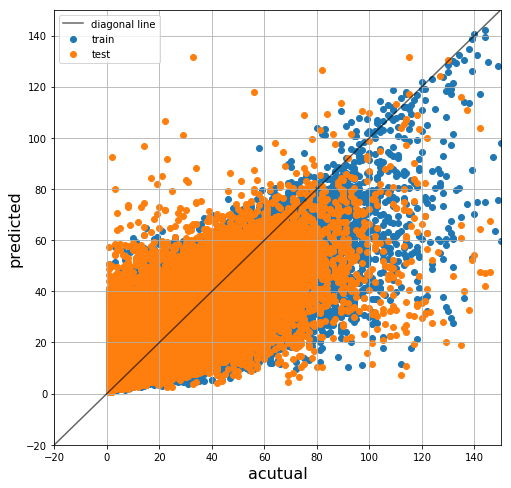

In [12]:
u_lim=150
l_lim=-20
plt.figure(figsize=(8, 8))
plt.plot([l_lim,u_lim], [l_lim,u_lim], c='k', alpha=0.6, label = 'diagonal line') # diagonal line
plt.scatter(y_train,y_train_pred,label='train')
plt.scatter(y_test,y_test_pred,label='test')
plt.xlim(l_lim,u_lim)
plt.ylim(l_lim,u_lim)
plt.xlabel('acutual', fontsize=16)
plt.ylabel('predicted', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [13]:
with open('../model/xgb.pickle', mode='wb') as f:
    pickle.dump(xgb0, f)